# Testing AudioMPS class

In [1]:
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

sys.path.append("../")

from model import AudioMPS

In [2]:
sess = tf.InteractiveSession()

## Load Data

In [3]:
BATCH_SIZE = 32

In [4]:
organ_dataset = tf.data.TFRecordDataset('../data/organ.tfrecords')

In [5]:
parse_function = lambda example_proto: tf.parse_single_example(example_proto,
                                                               {"audio": tf.FixedLenFeature([2**16], dtype=tf.float32)})

In [6]:
organ_dataset = organ_dataset.map(parse_function)  # Parse the record into tensors.

In [7]:
organ_dataset = organ_dataset.batch(batch_size=BATCH_SIZE).shuffle(buffer_size=10000).repeat()
organ_iterator = organ_dataset.make_one_shot_iterator()
organ_batch = organ_iterator.get_next()

In [8]:
organ_batch['audio']

<tf.Tensor 'IteratorGetNext:0' shape=(?, 65536) dtype=float32>

In [9]:
sess.run(tf.zeros_like(organ_batch['audio'][:,0]))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

An example waveform

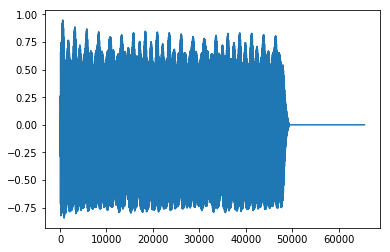

In [10]:
plt.plot(sess.run(organ_batch['audio'])[0])

Close up

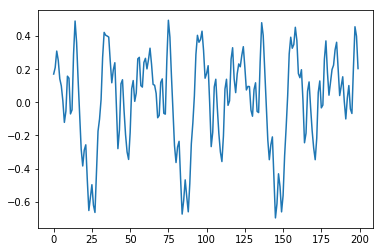

In [11]:
plt.plot(sess.run(organ_batch['audio'])[0][20000:20200])

## Checking the loss works

In [12]:
BOND_D = 5

In [13]:
organ_model = AudioMPS(organ_batch['audio'], BOND_D, delta_t=0.01)

(?, 5) (?,)


In [14]:
sess.run(tf.global_variables_initializer())

In [15]:
sess.run(organ_model.loss)

array([1546.9739 , 1262.8115 ,  309.98608, 2009.2977 , 3421.2815 ,
       3056.65   , 2195.4604 , 2522.9844 ,  720.3953 , 3829.6636 ,
        962.21027,  590.32886,  720.80066, 3127.7913 , 4455.748  ,
        763.7462 , 1018.44275, 1799.501  , 1132.9938 , 6057.3833 ,
       2166.7676 , 2038.642  , 2819.209  , 3127.777  ,  619.65173,
        887.2104 , 1924.6938 , 3428.2065 ,  606.76776, 3495.55   ,
       1699.6887 , 3908.8264 ], dtype=float32)